In [80]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [81]:
# Setting hyperparameters
batch_size = 64
epochs = 150
learning_rate = 0.001
hidden_shape = 64
num_layer = 1
l1 = False
l2 = False
lr_decay = False
model_type = "RNN"
# model_type = "GRU"
# model_type = "LSTM"

In [82]:
df = pd.read_csv("data/ac_data.csv")

df.head()

,date_time,temperature_datetime,temperature,airQuality_datetime,airQuality
0,2023-06-11 01:07:06.889863,2023-6-10-17-7-7,25.3750,2023-6-10-17-7-9,449
1,2023-06-11 01:12:07.465380,2023-6-10-17-12-4,25.3125,2023-6-10-17-12-8,461
2,2023-06-11 01:17:08.019617,2023-6-10-17-17-5,25.3125,2023-6-10-17-17-7,454
3,2023-06-11 01:22:08.641555,2023-6-10-17-22-8,25.1875,2023-6-10-17-22-9,460
4,2023-06-11 01:27:09.215907,2023-6-10-17-27-5,25.0625,2023-6-10-17-27-7,482


In [83]:
# Generating dataset

class device_data(Dataset):
    def __init__(self, X, window, horizon=0):
        self.X = []
        self.y = []
        self.len = X.shape[0]-window-1
        for i in range(0, len(X)-window-1-horizon):
            self.X.append(X[i:window+i])
            self.y.append(X[window+i: window+i+horizon+1])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return torch.Tensor(self.X[index]), torch.Tensor([self.y[index]])

In [84]:
scaler = MinMaxScaler()
scaler.fit(df["temperature"].to_numpy().reshape(-1, 1))
data = scaler.transform(df["temperature"].to_numpy().reshape(-1, 1))

In [85]:
# data = df["temperature"].to_numpy()

In [86]:
# Sequence lenght is 12. 1 hr duration
window = 12
horizon = 0

In [87]:
train = device_data(data.squeeze()[:800], window)
val = device_data(data.squeeze()[800:900], window)
test = device_data(data.squeeze()[900:], window)

In [88]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [89]:
dataset_iter = iter(train_loader)
temp = next(dataset_iter)
features, labels = temp
print(features.shape, labels.shape)

torch.Size([64, 12]) torch.Size([64, 1, 1])


In [90]:
class RNNForecasting(nn.Module):
    def __init__(self, model_type, seq_length, input_shape, hidden_shape, output_shape, num_layers):
        super(RNNForecasting, self).__init__()
        self.hidden = hidden_shape
        self.num_layers = num_layers
        self.model = model_type
        if model_type == "RNN":
            self.rnn = nn.RNN(input_shape, hidden_shape, num_layers=num_layers, batch_first=True)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_shape, hidden_shape, num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_shape, hidden_shape, num_layers=num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_shape * seq_length, output_shape)

    def forward(self, x):
        batch_size = x.size(0)
        if self.model == "RNN" or self.model == "GRU":
            # h = torch.zeros([self.num_layers, batch_size, self.hidden])
            h = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()
            out, h = self.rnn(x, h)
        else:
            h = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()
            c = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()
            out, _ = self.rnn(x, (h, c))
        
        out = self.linear(out.contiguous().view(out.shape[0], -1))

        return out

    def compute_l1(self, w):
        return torch.abs(w).sum()

    def compute_l2(self, w):
      return torch.square(w).sum()

In [91]:
# Test model,
input_shape = 1
output_shape = 1
test = RNNForecasting(model_type, window, input_shape, hidden_shape, output_shape, num_layer).cuda()
# (seq,btch,in_sh)
out = test(features.unsqueeze(2).cuda())
print(out.shape)

torch.Size([64, 1])


### RNN

In [92]:
input_shape = 1
output_shape = 1
model = RNNForecasting(model_type, window, input_shape, hidden_shape, output_shape, num_layers=num_layer).cuda()

In [93]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

Epoch:  0 train:  0.43373946173785527 val:  0.183432030394476
Epoch:  1 train:  0.23046890691575597 val:  0.1108302008328182
Epoch:  2 train:  0.18049192503101463 val:  0.11533202792341256
Epoch:  3 train:  0.13490078421234777 val:  0.08913278346949048
Epoch:  4 train:  0.10638135340340027 val:  0.09347169865212826
Epoch:  5 train:  0.08702858076689592 val:  0.09022699881991815
Epoch:  6 train:  0.08921110799769175 val:  0.08813483169926799
Epoch:  7 train:  0.09337331769517197 val:  0.08540814995983981
Epoch:  8 train:  0.09506341708017384 val:  0.08761016803666388
Epoch:  9 train:  0.08387319656368862 val:  0.08522386723474004
Epoch:  10 train:  0.08358421784022911 val:  0.08343411249188674
Epoch:  11 train:  0.08665668344047923 val:  0.08225819348032544
Epoch:  12 train:  0.08955794251480029 val:  0.08144409478241266
Epoch:  13 train:  0.08320697517433974 val:  0.08094085023471052
Epoch:  14 train:  0.0802298283799385 val:  0.0792034646353232
Epoch:  15 train:  0.08163116012187216 v

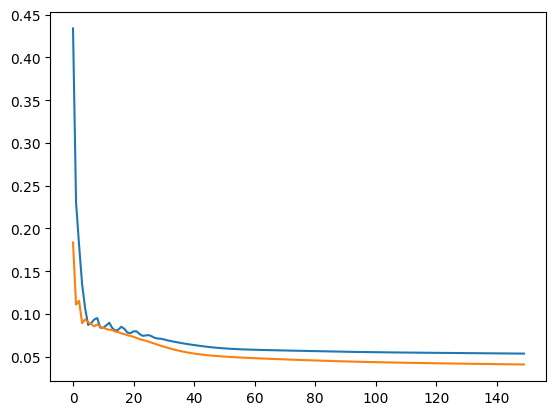

In [94]:
# Training
l1_weight = 0.01
l2_weight = 0.01
loss_train = []
loss_val = []
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.reshape(-1, 1).cuda()
        batch_x = batch_x.unsqueeze(2)
        optimizer.zero_grad()
        y_pred = model(batch_x)
        l = criterion(y_pred, batch_y)

        # Using l1 regularization
        # if l1:
        #     l1_parameters = []
        #     for parameter in model.parameters():
        #         l1_parameters.append(parameter.view(-1))
        #     L1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
        #     l += L1

        # # Using l2 regularization
        # if l2:
        #     l2_parameters = []
        #     for parameter in model.parameters():
        #         l2_parameters.append(parameter.view(-1))
        #     L1 = l2_weight * model.compute_l2(torch.cat(l2_parameters))
        #     l += L1

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    # if lr_decay:
    #     epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.reshape(-1, 1).cuda()
            batch_x = batch_x.unsqueeze(2)
            output = model(batch_x)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            # preds.append(output.detach().numpy())
            # true.append(batch_y.detach().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    print("Epoch: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)
    loss_train.append((mse_train/train.__len__())**0.5)
    loss_val.append((mse_val/val.__len__())**0.5)


plt.plot(loss_train)
plt.plot(loss_val)
plt.show()    

In [95]:
# Testing the model

with torch.no_grad():
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.reshape(-1, 1).cuda()
        batch_x = batch_x.unsqueeze(2)
        output = model(batch_x)
        # output = output.squeeze(1)
        preds.append(scaler.inverse_transform(output.detach().cpu().numpy()))
        true.append(scaler.inverse_transform(batch_y.detach().cpu().numpy()))

        # preds.append(output.detach().cpu().numpy())
        # true.append(batch_y.detach().cpu().numpy())

    preds = np.concatenate(preds)
    true = np.concatenate(true)

    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)

    print(mse, mae)

0.32591882 0.43490276


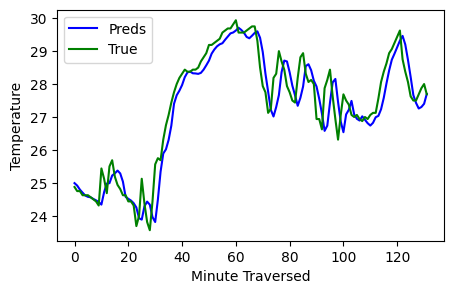

In [110]:
plt.figure(figsize=(5, 3))
# plt.plot(preds[2:], 'b', label='Preds')
# plt.plot(true[:-2], 'g', label='True')
plt.plot(preds, 'b', label='Preds')
plt.plot(true, 'g', label='True')
plt.legend()
plt.xlabel("Minute Traversed")
plt.ylabel("Temperature")
plt.show()

### GRU

In [97]:
# Setting hyperparameters
batch_size = 64
epochs = 150
learning_rate = 0.001
hidden_shape = 64
num_layer = 1
l1 = False
l2 = False
lr_decay = False
# model_type = "RNN"
model_type = "GRU"
# model_type = "LSTM"

In [98]:
input_shape = 1
output_shape = 1
model_gru = RNNForecasting(model_type, window, input_shape, hidden_shape, output_shape, num_layers=num_layer).cuda()

In [99]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

Epoch:  0 train:  0.4391333947271884 val:  0.13579962198360687
Epoch:  1 train:  0.25013419742896054 val:  0.12092084070897381
Epoch:  2 train:  0.20306659347591463 val:  0.10155887074483051
Epoch:  3 train:  0.15754169478720348 val:  0.10561016114223404
Epoch:  4 train:  0.11622168575453468 val:  0.09046500859466108
Epoch:  5 train:  0.09563910594014759 val:  0.09437529356020018
Epoch:  6 train:  0.08769788322971188 val:  0.09053884002160212
Epoch:  7 train:  0.08855390188918916 val:  0.08981299076341838
Epoch:  8 train:  0.08689149786106612 val:  0.0891959625605517
Epoch:  9 train:  0.08650431134617144 val:  0.08842121414180067
Epoch:  10 train:  0.08615391277576874 val:  0.08783527058595325
Epoch:  11 train:  0.0855139774094074 val:  0.08702764783228259
Epoch:  12 train:  0.08514051873840603 val:  0.08624017363669763
Epoch:  13 train:  0.08476233634378863 val:  0.08551158614650738
Epoch:  14 train:  0.08423024031723654 val:  0.08474935321588868
Epoch:  15 train:  0.0836854915920188 

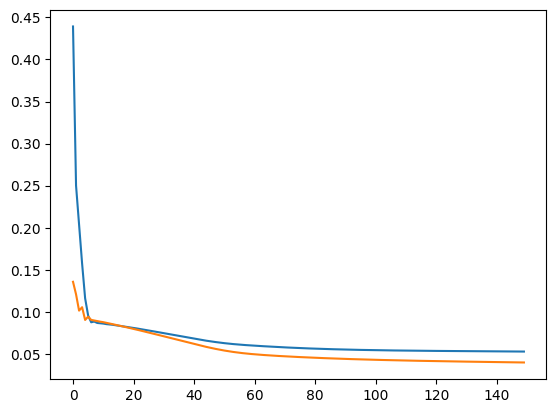

In [100]:
# Training
l1_weight = 0.01
l2_weight = 0.01
loss_train = []
loss_val = []
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.reshape(-1, 1).cuda()
        batch_x = batch_x.unsqueeze(2)
        optimizer.zero_grad()
        y_pred = model_gru(batch_x)
        l = criterion(y_pred, batch_y)

        # Using l1 regularization
        # if l1:
        #     l1_parameters = []
        #     for parameter in model.parameters():
        #         l1_parameters.append(parameter.view(-1))
        #     L1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
        #     l += L1

        # # Using l2 regularization
        # if l2:
        #     l2_parameters = []
        #     for parameter in model.parameters():
        #         l2_parameters.append(parameter.view(-1))
        #     L1 = l2_weight * model.compute_l2(torch.cat(l2_parameters))
        #     l += L1

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    # if lr_decay:
    #     epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.reshape(-1, 1).cuda()
            batch_x = batch_x.unsqueeze(2)
            output = model_gru(batch_x)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            # preds.append(output.detach().numpy())
            # true.append(batch_y.detach().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    print("Epoch: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)
    loss_train.append((mse_train/train.__len__())**0.5)
    loss_val.append((mse_val/val.__len__())**0.5)


plt.plot(loss_train)
plt.plot(loss_val)
plt.show()    

In [101]:
# Testing the model

with torch.no_grad():
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.reshape(-1, 1).cuda()
        batch_x = batch_x.unsqueeze(2)
        output = model(batch_x)
        # output = output.squeeze(1)
        preds.append(scaler.inverse_transform(output.detach().cpu().numpy()))
        true.append(scaler.inverse_transform(batch_y.detach().cpu().numpy()))

        # preds.append(output.detach().cpu().numpy())
        # true.append(batch_y.detach().cpu().numpy())

    preds = np.concatenate(preds)
    true = np.concatenate(true)

    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)

    print(mse, mae)

0.32591882 0.43490276


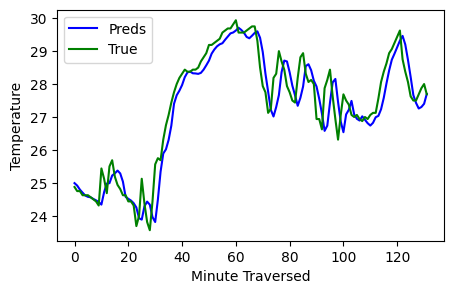

In [111]:
plt.figure(figsize=(5, 3))
# plt.plot(preds[2:], 'b', label='Preds')
# plt.plot(true[:-2], 'g', label='True')
plt.plot(preds, 'b', label='Preds')
plt.plot(true, 'g', label='True')
plt.legend()
plt.xlabel("Minute Traversed")
plt.ylabel("Temperature")
plt.show()

### LSTM

In [103]:
# Setting hyperparameters
batch_size = 64
epochs = 150
learning_rate = 0.001
hidden_shape = 64
num_layer = 1
l1 = False
l2 = False
lr_decay = False
# model_type = "RNN"
# model_type = "GRU"
model_type = "LSTM"

In [104]:
input_shape = 1
output_shape = 1
model_lstm = RNNForecasting(model_type, window, input_shape, hidden_shape, output_shape, num_layers=num_layer).cuda()

In [105]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

Epoch:  0 train:  0.48109931346296275 val:  0.13853705189734938
Epoch:  1 train:  0.2638941045416169 val:  0.15169708319413017
Epoch:  2 train:  0.22662864290860535 val:  0.11098160906643442
Epoch:  3 train:  0.1980358811038639 val:  0.10713092302151879
Epoch:  4 train:  0.1580526926379979 val:  0.09529801526944374
Epoch:  5 train:  0.12714351024675186 val:  0.09394086577060981
Epoch:  6 train:  0.09398757898321847 val:  0.09180897226944697
Epoch:  7 train:  0.09158076086202616 val:  0.0911909571103936
Epoch:  8 train:  0.08934447129543031 val:  0.0895380579752543
Epoch:  9 train:  0.091555855309668 val:  0.09015773371877224
Epoch:  10 train:  0.08829169409182376 val:  0.08958417769184299
Epoch:  11 train:  0.08769640122673121 val:  0.08879689641768694
Epoch:  12 train:  0.08817087382071495 val:  0.08797927224982664
Epoch:  13 train:  0.08840118152981107 val:  0.08803231424477803
Epoch:  14 train:  0.08668344029298275 val:  0.0875379167031458
Epoch:  15 train:  0.08629318556258729 val:

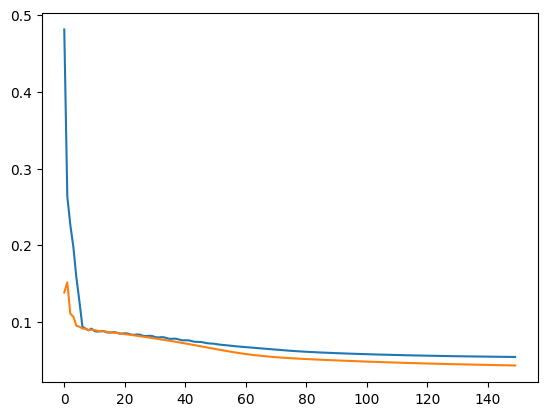

In [106]:
# Training
l1_weight = 0.01
l2_weight = 0.01
loss_train = []
loss_val = []
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.reshape(-1, 1).cuda()
        batch_x = batch_x.unsqueeze(2)
        optimizer.zero_grad()
        y_pred = model_lstm(batch_x)
        l = criterion(y_pred, batch_y)

        # Using l1 regularization
        # if l1:
        #     l1_parameters = []
        #     for parameter in model.parameters():
        #         l1_parameters.append(parameter.view(-1))
        #     L1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
        #     l += L1

        # # Using l2 regularization
        # if l2:
        #     l2_parameters = []
        #     for parameter in model.parameters():
        #         l2_parameters.append(parameter.view(-1))
        #     L1 = l2_weight * model.compute_l2(torch.cat(l2_parameters))
        #     l += L1

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    # if lr_decay:
    #     epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.reshape(-1, 1).cuda()
            batch_x = batch_x.unsqueeze(2)
            output = model_lstm(batch_x)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            # preds.append(output.detach().numpy())
            # true.append(batch_y.detach().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    print("Epoch: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)
    loss_train.append((mse_train/train.__len__())**0.5)
    loss_val.append((mse_val/val.__len__())**0.5)


plt.plot(loss_train)
plt.plot(loss_val)
plt.show()    

In [107]:
# Testing the model

with torch.no_grad():
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.reshape(-1, 1).cuda()
        batch_x = batch_x.unsqueeze(2)
        output = model(batch_x)
        # output = output.squeeze(1)
        preds.append(scaler.inverse_transform(output.detach().cpu().numpy()))
        true.append(scaler.inverse_transform(batch_y.detach().cpu().numpy()))

        # preds.append(output.detach().cpu().numpy())
        # true.append(batch_y.detach().cpu().numpy())

    preds = np.concatenate(preds)
    true = np.concatenate(true)

    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)

    print(mse, mae)

0.32591882 0.43490276


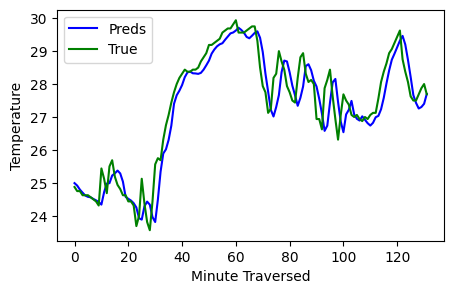

In [112]:
plt.figure(figsize=(5, 3))
# plt.plot(preds[2:], 'b', label='Preds')
# plt.plot(true[:-2], 'g', label='True')
plt.plot(preds, 'b', label='Preds')
plt.plot(true, 'g', label='True')
plt.legend()
plt.xlabel("Minute Traversed")
plt.ylabel("Temperature")
plt.show()

### Saving config

In [109]:
# Creating/updating config file with hyperparameters and model performance
import os
from pathlib import Path
import json

filepath = "config/config.json"
filepath = Path(filepath)
filedir, filename = os.path.split(filepath)

dic = {
    "model": model_type,
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "hidden_shape": hidden_shape,
    "num_layer": num_layer,
    "l1": l1,
    "l2": l2,
    "lr_decay": lr_decay,
    "MAE": str(mae),
    "MSE": str(mse),
    "window_size": str(window),
    "horizon": str(horizon)
}

# Serializing json
json_object = json.dumps(dic, indent=4)

try:
    with open(filepath, "r") as file:
        existing_data = json.load(file)
        existing_data.append(json_object)
        with open(filepath, "w") as file:
            json.dump(existing_data, file, indent=None)
        print("New configuration for the model added")
except FileNotFoundError:
    if filedir != "":
        os.makedirs(filedir, exist_ok=True)
        print(f"Creating directory:{filedir} for the file {filename}")

    existing_data = []
    existing_data.append(json_object)
    with open(filepath, "w") as file:
        json.dump(existing_data, file, indent=None)

    print("New config file is created with first configuration for the model")
        

New configuration for the model added
